## Imports

In [1]:
import time
t0start = time.time()
from fastai.collab import *
from fastai.tabular.all import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
random_seed = 42

In [3]:
from transformers import set_seed
set_seed(random_seed)

## Prepare Train Set

Here I read the training data and melt it to yield a ```DataFrame``` with three categorical features (```cell_type```, ```sm_name```, and ```gene```) and one target (```value```).

In [4]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df_de_train = pd.read_parquet(fn)# , index_col = 0)
train_df = df_de_train.drop(columns=['sm_lincs_id', 'SMILES', 'control'])
trdf = train_df.melt(id_vars=['cell_type', 'sm_name'], value_vars=train_df.iloc[:,2:].columns, var_name='gene', value_name='value')

CPU times: user 3.98 s, sys: 807 ms, total: 4.79 s
Wall time: 5.21 s


The next line samples 5 % of the training data to demonstrate model training in a reasonable time frame:

In [5]:
trdf = trdf.sample(frac=0.05).reset_index(drop=true)
display(trdf)

,cell_type,sm_name,gene,value
0,NK cells,Sunitinib,LINC00824,0.243416
1,NK cells,Lamivudine,CCDC61,-0.104237
2,T cells CD4+,Ceritinib,PSMD6,0.276361
3,NK cells,Isoniazid,KIF3B,-0.135494
4,T cells CD4+,GSK-1070916,TSGA13,-0.286420
...,...,...,...,...
559073,T cells CD8+,BAY 61-3606,AC108673.2,3.826006
559074,T regulatory cells,Dactolisib,TMEM71,2.750107
559075,T cells CD4+,Chlorpheniramine,VAMP3,0.033372
559076,NK cells,Amiodarone,LINC02325,-0.170687


## Prepare Test Set

Similar procedure for the test set.

In [6]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)
fn = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
df = pd.read_csv(fn, index_col = 0)

cols_to_add = df_de_train.iloc[:,5:].columns
display(cols_to_add)

df_zeros = pd.DataFrame(0.0, columns=cols_to_add, index=df_id_map.index)
display(df_zeros)

df_id_map_preds = pd.concat([df_id_map, df_zeros], axis=1)
tsdf = df_id_map_preds.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_id_map_preds.iloc[:,3:].columns, var_name='gene', value_name='value')
display(tsdf)

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1', 'A4GALT', 'AAAS', 'AACS',
       'AAGAB', 'AAK1',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18211)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,cell_type,sm_name,gene,value
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,A1BG,0.0
1,B cells,ABT-199 (GDC-0199),A1BG,0.0
2,B cells,ABT737,A1BG,0.0
3,B cells,AMD-070 (hydrochloride),A1BG,0.0
4,B cells,AT 7867,A1BG,0.0
...,...,...,...,...
4643800,Myeloid cells,Vandetanib,ZZEF1,0.0
4643801,Myeloid cells,Vanoxerine,ZZEF1,0.0
4643802,Myeloid cells,Vardenafil,ZZEF1,0.0
4643803,Myeloid cells,Vorinostat,ZZEF1,0.0


## Inspect Train and Test Set

In [7]:
trdf

,cell_type,sm_name,gene,value
0,NK cells,Sunitinib,LINC00824,0.243416
1,NK cells,Lamivudine,CCDC61,-0.104237
2,T cells CD4+,Ceritinib,PSMD6,0.276361
3,NK cells,Isoniazid,KIF3B,-0.135494
4,T cells CD4+,GSK-1070916,TSGA13,-0.286420
...,...,...,...,...
559073,T cells CD8+,BAY 61-3606,AC108673.2,3.826006
559074,T regulatory cells,Dactolisib,TMEM71,2.750107
559075,T cells CD4+,Chlorpheniramine,VAMP3,0.033372
559076,NK cells,Amiodarone,LINC02325,-0.170687


In [8]:
tsdf

,cell_type,sm_name,gene,value
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,A1BG,0.0
1,B cells,ABT-199 (GDC-0199),A1BG,0.0
2,B cells,ABT737,A1BG,0.0
3,B cells,AMD-070 (hydrochloride),A1BG,0.0
4,B cells,AT 7867,A1BG,0.0
...,...,...,...,...
4643800,Myeloid cells,Vandetanib,ZZEF1,0.0
4643801,Myeloid cells,Vanoxerine,ZZEF1,0.0
4643802,Myeloid cells,Vardenafil,ZZEF1,0.0
4643803,Myeloid cells,Vorinostat,ZZEF1,0.0


## Prepare Transformer Input

In [9]:
trdf['input'] = "Estimate the −log(p-value) confidence for change in gene expression of " + trdf.gene + " in " + trdf.cell_type + " when treated with " + trdf.sm_name + " compared to DMSO."
print(trdf.input[0])
trdf.input.head()

Estimate the −log(p-value) confidence for change in gene expression of LINC00824 in NK cells when treated with Sunitinib compared to DMSO.


0       Estimate the −log(p-value) confidence for change in gene expression of LINC00824 in NK cells when treated with Sunitinib compared to DMSO.
1         Estimate the −log(p-value) confidence for change in gene expression of CCDC61 in NK cells when treated with Lamivudine compared to DMSO.
2       Estimate the −log(p-value) confidence for change in gene expression of PSMD6 in T cells CD4+ when treated with Ceritinib compared to DMSO.
3           Estimate the −log(p-value) confidence for change in gene expression of KIF3B in NK cells when treated with Isoniazid compared to DMSO.
4    Estimate the −log(p-value) confidence for change in gene expression of TSGA13 in T cells CD4+ when treated with GSK-1070916 compared to DMSO.
Name: input, dtype: object

In [10]:
tsdf['input'] = "Estimate the −log(p-value) confidence for change in gene expression of " + tsdf.gene + " in " + tsdf.cell_type + " when treated with " + tsdf.sm_name + " compared to DMSO."
print(trdf.input[0])
print(tsdf.input[0])

Estimate the −log(p-value) confidence for change in gene expression of LINC00824 in NK cells when treated with Sunitinib compared to DMSO.
Estimate the −log(p-value) confidence for change in gene expression of A1BG in B cells when treated with 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine compared to DMSO.


In [11]:
from datasets import Dataset, DatasetDict
trds = Dataset.from_pandas(trdf)
trds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'value', 'input'],
    num_rows: 559078
})

In [12]:
tsds = Dataset.from_pandas(tsdf)
tsds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'value', 'input'],
    num_rows: 4643805
})

## Prepare Model

### Tokenize

In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_nm = 'nlpie/tiny-biobert'
tokz = AutoTokenizer.from_pretrained(model_nm)

# @misc{https://doi.org/10.48550/arxiv.2209.03182,
#   doi = {10.48550/ARXIV.2209.03182},
#   url = {https://arxiv.org/abs/2209.03182},
#   author = {Rohanian, Omid and Nouriborji, Mohammadmahdi and Kouchaki, Samaneh and Clifton, David A.},
#   keywords = {Computation and Language (cs.CL), Machine Learning (cs.LG), FOS: Computer and information sciences, FOS: Computer and information sciences, 68T50},
#   title = {On the Effectiveness of Compact Biomedical Transformers},
#   publisher = {arXiv},
#   year = {2022}, 
#   copyright = {arXiv.org perpetual, non-exclusive license}
# }


tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
L(tokz.tokenize(trds['input'][0]))

(#41) ['E','##st','##imate','the','−','##log','(','p','-','value'...]

In [15]:
print('Started tokenization...')
def tok_func(x): return tokz(x["input"])

tok_trds = trds.map(tok_func, batched = True)
tok_tsds = tsds.map(tok_func, batched = True)

Started tokenization...


  0%|          | 0/560 [00:00<?, ?ba/s]

  0%|          | 0/4644 [00:00<?, ?ba/s]

In [16]:
print(tok_trds[0]['input']), L(tok_trds[0]['input_ids'])

Estimate the −log(p-value) confidence for change in gene expression of LINC00824 in NK cells when treated with Sunitinib compared to DMSO.


(None, (#43) [101,142,2050,15774,1103,851,13791,113,185,118...])

In [17]:
print(tok_tsds[0]['input']), L(tok_tsds[0]['input_ids'])

Estimate the −log(p-value) confidence for change in gene expression of A1BG in B cells when treated with 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine compared to DMSO.


(None, (#79) [101,142,2050,15774,1103,851,13791,113,185,118...])

In [18]:
len(tokz)

28996

In [19]:
for i in tok_tsds[0]['input_ids']:
    print(tokz.decode(i))

[CLS]
E
##st
##imate
the
−
##log
(
p
-
value
)
confidence
for
change
in
gene
expression
of
A1
##B
##G
in
B
cells
when
treated
with
5
-
(
9
-
Is
##op
##rop
##yl
-
8
-
met
##hyl
-
2
-
m
##or
##ph
##olin
##o
-
9
##H
-
pu
##rin
-
6
-
y
##l
)
p
##yr
##im
##id
##in
-
2
-
am
##ine
compared
to
D
##MS
##O
.
[SEP]


In [20]:
tok_trds = tok_trds.rename_columns({"value":"labels"})
tok_trds

Dataset({
    features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 559078
})

### Split Train Data

In [21]:
dds = tok_trds.train_test_split(0.20, seed=random_seed)
dds

DatasetDict({
    train: Dataset({
        features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 447262
    })
    test: Dataset({
        features: ['cell_type', 'sm_name', 'gene', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111816
    })
})

### Define Model

In [22]:
bs = 256
epochs = 5
lr = 8e-5

In [23]:
steps = len(dds['train']) // bs
steps

1747

In [24]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments('outputs', save_steps=steps, learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none', seed=random_seed) # resume_from_checkpoint="/kaggle/working/20231005/outputs/checkpoint-104826", fp16=True

In [25]:
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    labels = p.label_ids
    rmse = np.sqrt(((preds - labels) ** 2).mean())
    return {"rmse": rmse}

In [26]:
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/working/tinybiobert_tasked_one_sentence_5eps42", num_labels=1) # for checkpoint use e.g. "/kaggle/working/20231005/outputs/checkpoint-104826" instead of model_nm
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz)

## Training

In [27]:
print('Started training...')
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Started training...


Epoch,Training Loss,Validation Loss
1,2.548500,4.210702
2,2.962700,3.609612
3,2.729400,3.603174
4,2.966500,3.467669
5,2.736600,3.525657


TrainOutput(global_step=8740, training_loss=2.826531528499088, metrics={'train_runtime': 2246.0565, 'train_samples_per_second': 995.661, 'train_steps_per_second': 3.891, 'total_flos': 4897005590377812.0, 'train_loss': 2.826531528499088, 'epoch': 5.0})

In [28]:
model_string = 'opxtinybiobert_5eps'
trainer.save_model(f'./{model_string}/')

In [29]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_nm = 'nlpie/distil-biobert'
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

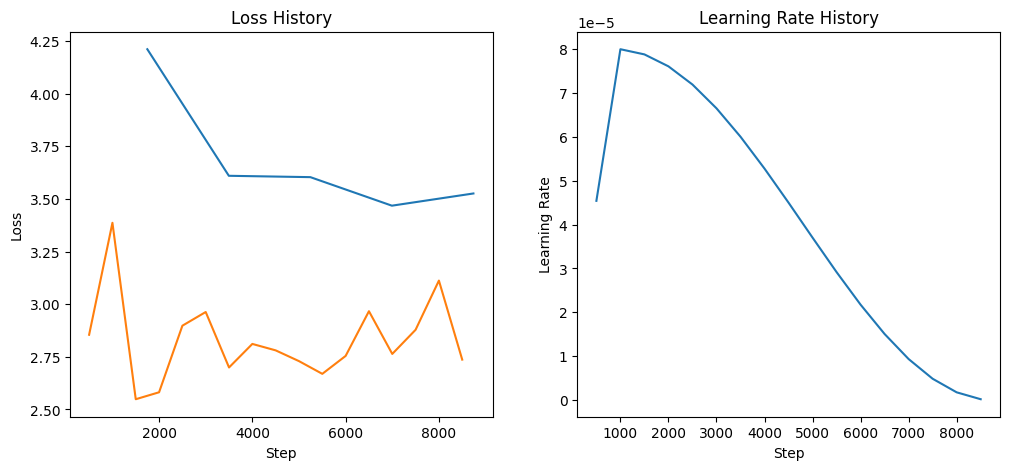

In [30]:
valid_loss_history = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
valid_step_history = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
train_loss_history = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
train_step_history = [log['step'] for log in trainer.state.log_history if 'loss' in log]
lrate_history = [log['learning_rate'] for log in trainer.state.log_history if 'loss' in log]
epoch_history = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(valid_step_history, valid_loss_history)
ax1.plot(train_step_history, train_loss_history)
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Loss History')

ax2.plot(train_step_history, lrate_history)
ax2.set_xlabel('Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate History')

plt.savefig(f'{model_string}_training.pdf', format='pdf')
plt.tight_layout
plt.show()

In [31]:
with open(f'{model_string}_training_history.txt', 'w') as file:
    file.write(str(trainer.state.log_history))

## Predict

In [ ]:
print('Started inference...')
preds = trainer.predict(tok_tsds).predictions.astype(float)
preds

Started inference...


In [ ]:
preds.max(), preds.min()

In [ ]:
preds_rounded = np.round_(preds, 4)
preds_rounded

In the last step I reshape the predictions back into a 255 x 18211 tensor for submission:

In [ ]:
to_submit = preds_rounded.reshape(18211, -1).T

In [ ]:
submit = pd.DataFrame(to_submit, columns=df_de_train.iloc[:,5:].columns)
submit.index.name = 'id'
submit

In [ ]:
submit.to_csv(f'submission.csv')